In [12]:
from utils_dino import *
import time

start_time = time.time()


In [13]:
SOURCE_IMAGE_PATH = r"D:\3d-recon\datasets\ASARoomImage\Bedroom2.JPG"

wall_bboxes, wall_selected_points = get_wall_bboxes_points(SOURCE_IMAGE_PATH)

print("wall_bboxes", wall_bboxes)
print("wall_selected_points", wall_selected_points)

# print(type(wall_bboxes))
# print(wall_bboxes.shape)

# print(type(wall_selected_points))
# print(len(wall_selected_points))

Getting wall mask from  D:\3d-recon\datasets\ASARoomImage\Bedroom2.JPG
wall_bboxes [[1.6128845e+00 3.8519287e-01 9.4747998e+02 1.0576101e+03]
 [1.4419229e+03 7.7176422e+01 1.9976238e+03 1.0238474e+03]]
wall_selected_points [[362, 399], [1717, 475]]


In [14]:
(floor_bboxes, 
 floor_selected_points, 
 rug_bboxes,
 rug_to_floor_indices) = get_floor_bboxes_points_with_rug(SOURCE_IMAGE_PATH)

print("floor_bboxes", floor_bboxes)
print("floor_selected_points", floor_selected_points)

print("rug_bboxes", rug_bboxes)
print("rug_to_floor_indices", rug_to_floor_indices)

# print(type(floor_bboxes))
# print(floor_bboxes.shape)

# print(type(floor_selected_points))
# print(len(floor_selected_points))

# print(type(rug_bboxes))
# print(rug_bboxes.shape)

RUG:  0
No overlap
RUG BBOX 579.0536 988.9951 1639.9325 1296.9045
FLOOR BBOX 1.7269287109375 984.7381591796875 1998.60595703125 1332.4591064453125
YES bbox is inside Floor area
floor_bboxes [[   2.7269287  985.73816   1997.606     1331.4591   ]]
floor_selected_points [[1254, 1174]]
rug_bboxes [[ 579.0536  988.9951 1639.9325 1296.9045]]
rug_to_floor_indices [[0]]


# Output for Client

In [15]:
output = {'wall_bboxes': wall_bboxes,
          'wall_selected_points':wall_selected_points,
          'floor_bboxes':floor_bboxes,
          'floor_selected_points': floor_selected_points,
          'rug_bboxes': rug_bboxes,
          'rug_to_floor_indices':rug_to_floor_indices}
print(time.time()-start_time)
output

2.409693956375122


{'wall_bboxes': array([[1.6128845e+00, 3.8519287e-01, 9.4747998e+02, 1.0576101e+03],
        [1.4419229e+03, 7.7176422e+01, 1.9976238e+03, 1.0238474e+03]],
       dtype=float32),
 'wall_selected_points': [[362, 399], [1717, 475]],
 'floor_bboxes': array([[   2.7269287,  985.73816  , 1997.606    , 1331.4591   ]],
       dtype=float32),
 'floor_selected_points': [[1254, 1174]],
 'rug_bboxes': array([[ 579.0536,  988.9951, 1639.9325, 1296.9045]], dtype=float32),
 'rug_to_floor_indices': [[0]]}

In [16]:
import time

start_time = time.time()

image = cv2.imread(SOURCE_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

checkpoint = r"./sam_vit_h_4b8939.pth"

model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

print(time.time()-start_time)

sam.to(device='cuda')
predictor = SamPredictor(sam)
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()

np.save("image_embedding_vith.npy", image_embedding)

print(time.time()-start_time)

(1333, 2000, 3)
3.126037120819092
4.37647819519043


In [17]:
print(image.shape)

(1333, 2000, 3)


In [18]:
def get_onnx_mask_from_bboxes(bboxes, ort_session):

    onnx_coord = np.concatenate([xyxy.reshape(1,2,2) for xyxy in bboxes], axis=0)#[None, :, :]
    onnx_label = np.concatenate([np.array([2,3]).reshape(1,2) for _ in range(bboxes.shape[0])], axis=0).astype(np.float32) #[None, :].astype(np.float32)

    print(onnx_coord.shape)
    print(onnx_label.shape)

    print(image.shape[:2])

    onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

    onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
    onnx_has_mask_input = np.zeros(1, dtype=np.float32)

    ort_inputs = {
        "image_embeddings": image_embedding,
        "point_coords": onnx_coord,
        "point_labels": onnx_label,
        "mask_input": onnx_mask_input,
        "has_mask_input": onnx_has_mask_input,
        "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
    }

    masks, _, _ = ort_session.run(None, ort_inputs)
    masks = masks > predictor.model.mask_threshold
    print(masks.shape)

    return masks

In [19]:
import onnxruntime

onnx_model_path = "sam_onnx_vith_batch.onnx"
ort_session = onnxruntime.InferenceSession(onnx_model_path)
wall_masks = get_onnx_mask_from_bboxes(wall_bboxes, ort_session)

ort_session = onnxruntime.InferenceSession(onnx_model_path)
floor_masks = get_onnx_mask_from_bboxes(floor_bboxes, ort_session)

if len(rug_bboxes)>0:
    ort_session = onnxruntime.InferenceSession(onnx_model_path)
    rug_masks = get_onnx_mask_from_bboxes(rug_bboxes, ort_session)

(2, 2, 2)
(2, 2)
(1333, 2000)
(2, 1, 1333, 2000)
(1, 2, 2)
(1, 2)
(1333, 2000)
(1, 1, 1333, 2000)
(1, 2, 2)
(1, 2)
(1333, 2000)
(1, 1, 1333, 2000)


In [20]:
# Step 1: Convert to uint8 (0 and 255)
mask_uint8 = (wall_masks[0].squeeze() * 255).astype(np.uint8)  # shape becomes (2657, 1920)

# Step 2: Save as JPG
cv2.imwrite("wall_mask.jpg", mask_uint8)

True

(1, 1333, 2000)
(1, 1333, 2000)


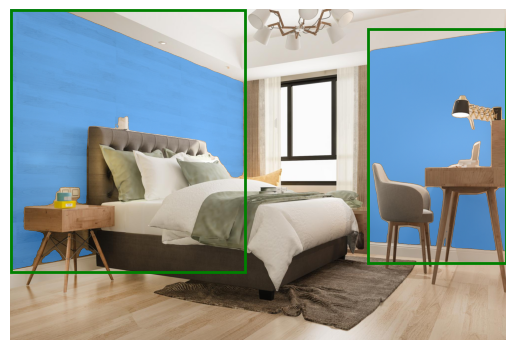

True

In [21]:
plt.imshow(image)

for mask, bbox in zip(wall_masks, wall_bboxes):
    print(mask.shape)
    show_mask(mask, plt.gca())
    show_box(bbox, plt.gca())
plt.axis('off')
plt.show()

# Step 1: Convert to uint8 (0 and 255)
mask_uint8 = (mask.squeeze() * 255).astype(np.uint8)  # shape becomes (2657, 1920)

# Step 2: Save as JPG
cv2.imwrite("mask.jpg", mask_uint8)

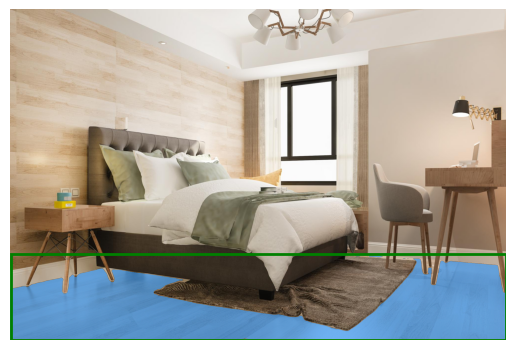

In [22]:
plt.imshow(image)

for mask, bbox in zip(floor_masks, floor_bboxes):
    show_mask(mask, plt.gca())
    show_box(bbox, plt.gca())
plt.axis('off')
plt.show()

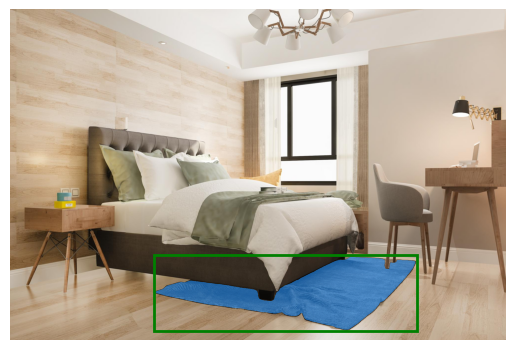

In [27]:
if len(rug_masks)>0:
    plt.imshow(image)

    for mask, bbox in zip(rug_masks, rug_bboxes):
        show_mask(mask, plt.gca())
        show_box(bbox, plt.gca())
    plt.axis('off')
    plt.show()